# Implementation of Monte Carlo simulation with PI controller
Ashish Bhattarai and Bernt Lie
University of South-Eastern Norway
Porsgrunn, May 2021

In [ ]:
using Plots
addprocs()
@everywhere using DifferentialEquations
using Distributions
using Distributed
using LaTeXStrings
using LinearAlgebra
pyplot();
using SparseArrays
using StaticArrays
using JLD    #used to store the data

In [ ]:
LW1 = 2.5;
LCoil = :darkred;
LCwater = :blue;
# Plotting befor and after together
figpath = "D:/USN/Asis/MS_Thesis/USN-MSc-Lyx-Template/fig/"

In [321]:
################Constants########
g = 9.81;   #acceleration due to gravity
d2s = 86400.0;  #Factor to convert day to seconds

#Reservoir dimension
R = 200;  #in meters
L = 1200;  #in meters

#curve fitting parameters obtained from saturation and permeability data
fit1 = 3.4830677845851046;
fit2 = 0.00043971820694883656;
fit3 = 3.5326302833873475;
fit4 = 2.6282606178861068;

###########Grid size#############
m = 20; #number of grids along R
n = 20; #number of grids along L
Delr = R/m;   #step length along R
Dell = L/n;   #step length along L

##########Fluid properties########
rhoo = 950.0;  #Density of oil
rhow = 1050.0; #Density of water
uo = 100e-3;    #Oil viscosity
uw = 1e-3;   #Water viscosity

#######Rock properties##########
K_R = 1.0*1.4803849e-12;   #Absolue permability of rock along r
K_L = 1.0*1.4803849e-12;   #Absolue permability of rock along l
K_eff = sqrt(K_R*K_L);  #Effective permeability
alpha = 20*pi/180;      #Inclination angle of a wedge shaped reservoir
beta = 25*pi/180;    #arch angle of a wedge shaped reservoir
theta = alpha + beta/2;
phi = 0.27;   #rock porosity

##########Aquifier properties##########
Kwa = 1.0;    #Relative permeability of aquifer
P_a = 115e5;  # Aquifier pressure

##########Well properties#############
rw = 0.124/2.0;  #Well radius
re = 0.5*Delr;    #equivalent radius
Lw = 1200;   #Well length
Del_Lp = Dell;   #pipe step length
Nv = n;  #Number of valves
Qtot = 0.00925926;    #total specified flow rate
Ar = pi*0.003217^2/4.0;  #Orifice are

##########Array allocation for pentadiagonal matrix and other matrices##########
B_sparse = sparse(zeros(Float64, m*n,m*n));  #Column vector of size m*n, used sparse matrix to speed up the simulation
A_sparse = sparse(zeros(Float64, m*n,m*n));  #pentadiagonal matrix of dimension m*n x m*n, used sparse matrix to speed up the simulation
v = zeros(Float64, m*n);       #column vector of size m*n
P = zeros(Float64, m*n);       #matrix of dimension m x n for pressure at each block

############Arrays to store fluid flow rates,combined density and well pressure#########
qmix = zeros(Float64,n,1);
q_w = zeros(Float64,n,1);  #Water flow rate
prw = zeros(Float64,n,1);     #initialize for well pressure
rho_mix = zeros(Float64,n,1);

############PI controller########
Err = zeros(Float64,4,1);
u1 = zeros(Float64,4,1);
z1 = zeros(Float64,4,1);
uAc = zeros(Float64,4,1);
u0 = 1.0;
kp = 1/(13.32*10000);
Ti = 2*17000*d2s;
Ts = 1*d2s;

#  Function to calculate permeability and to update water saturation

In [ ]:
function UpdatePerm(Sat)
    Perm_w = zeros(Float64, m,n);
    Perm_o = zeros(Float64, m,n);
    for i = 1:1:m
        for j = 1:1:n
            if Sat[i,j] >= 1.0
                Sat[i,j] = 1.0;
                Perm_w[i,j] = 1.0;
                Perm_o[i,j] = 0.0;
            elseif Sat[i,j] > 0.0;
                Perm_w[i,j] = Sat[i,j]^fit1 + fit2;
                Perm_o[i,j] = (1.0 -Sat[i,j])^fit3 * (1.0 -Sat[i,j]^fit4);
            else
                Sat[i,j] = 0.0;
                Perm_w[i,j] = 0.0;
                Perm_o[i,j] = 1.0;
            end
        end
    end
    return [Sat,Perm_w,Perm_o];
end

 # Function to calcuate fluid flow distribution at the well

In [ ]:
function Borehole_PI(prw,Qtot,A_1,A_2,A_3,A_4,rhomix)
    Area = zeros(Nv,1);
    Q = zeros(Nv+1,1);
    pbh = zeros(Nv+1,1);
    pbh_upper_limit = 85e5;
    pbh_lower_limit = 10e5;
    Area[1:5] .= A_1;   #giving same control input signal to ICVs number 1 to 5
    Area[6:10] .= A_2;   #giving same control input signal to ICVs number 6 to 10
    Area[11:15] .= A_3;  #giving same control input signal to ICVs number 11 to 15
    Area[16:20] .= A_4;  #giving same control input signal to ICVs number 16 to 20
    Q[1] = Qtot;
    q = zeros(Nv,1);
    a = Qtot/Nv;
    b = -a^2 *(Cu*mean(rhomix))/(Cv^2*(mean(Area))^2) + mean(prw[1:Nv]);
    pbh[1] = b - fr*mean(rhomix)*8*Del_Lp/(pi^2*(2*rp)^5)*Qtot;
    if pbh[1] > pbh_upper_limit
        pbh[1] = pbh_upper_limit;
    end
    for i = 1:Nv
        pbh[i+1]=pbh[i]+fr*rhomix[i]*8*Del_Lp/(pi^2*(2*rp)^5)*Q[i];
        if (prw[i]-pbh[i+1])<0.0
            break;
        end
        q[i]=sqrt((prw[i]-pbh[i+1])*Cv^2*Area[i]^2/(Cu*rhomix[i]));
        Q[i+1] = Q[i] - q[i];
        if Q[i+1] <=0.0
            break;
        end
    end
    return [q,pbh[1]];
end

# Function to calculate pressure equation

In [ ]:
function PressureCalc(Krw,Kro,qmix)
    f = zeros(Float64, m*n);       #column vector of size m*n
    #For blocks at i = 1 and j = 1
    i = 1;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = R;
    ro = R - i*Delr;
    T_a = (Kwa/uw)*K_eff;
    T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_a = (Kwa*rhow/uw)*K_eff;
    E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
    A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*T_i1j;
    A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
    A_sparse[z,z+n] = (1/(r*Delr^2))*ro*T_ij;
    f[1] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*( E_ij*ro - E_a*ri)*g*sin(theta);
    #For blocks at i = 1 and j = 2:n-1
    i = 1;
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-1] = (1/(Dell^2))*T_ij;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*(T_ij + T_i1j);
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        A_sparse[z,z+n] = (1/(r * Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*(E_ij*ro - E_a*ri)*g*sin(theta);
    end
    #For blocks at i = 1 and j = n
    i = 1;
    j = n;
    z = n*(i-1)+j;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
    A_sparse[z,z-1] = (1/Dell^2)*T_ij;
    A_sparse[z,z] = -(1/(r*Delr^2))*(T_a*ri+T_ij*ro)-(1/Dell^2)*T_ij;
    A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
    f[z] = -(1/(r*Delr^2))*T_a*ri*P_a - (1/(r*Delr))*(E_ij*ro - E_a*ri)*g*sin(theta);
    
    #For blocks at i = 2(m-1) and j = 2:(n-1)
    for i = 2:1:m-1
        r = R + (0.5-i)*Delr;
        ri = r + 0.5*Delr;
        ro = r - 0.5*Delr;
        for j = 2:1:n-1
            z = n*(i-1)+j;
            T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
            T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
            T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
            E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
            E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
            A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
            A_sparse[z,z-1] = (1/Dell^2)*T_ij;
            A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*(T_i1j+T_ij);
            A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
            A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
            f[z] = -(1/(r*Delr))*( E_ij*ro - E_ij1*ri)*g*sin(theta);
        end
        #For blocks at j = 1 and i = 2:m-1
        j = 1;
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*T_i1j;
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr))*(E_ij*ro - E_ij1*ri)*g*sin(theta);
        #For blocks at j = n and i = 2:m-1
        j = n;
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        E_ij = (Kro[i,j]*rhoo/uo + Krw[i,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r*Delr^2))*T_ij1*ri;
        A_sparse[z,z-1] = (1/Dell^2)*T_ij;
        A_sparse[z,z] = -(1/(r*Delr^2))*(T_ij1*ri+T_ij*ro)-(1/Dell^2)*T_ij;
        A_sparse[z,z+n] = (1/(r*Delr^2))*T_ij*ro;
        f[z] = -(1/(r*Delr))*(E_ij*ro - E_ij1*ri)*g*sin(theta);
    end
    
    #For blocks at i = m and j = 1
    i = m;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = r + 0.5*Delr;
    ro = r - 0.5*Delr;
    T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
    T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
    E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
    A_sparse[z,z-n] = (1/(r*Delr^2))*ri*T_ij1;
    A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*T_i1j;
    A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
    f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    #For blocks at i = m and j = n
    j = n;
    z = n*(i-1)+j;
    T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
    T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
    E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
    A_sparse[z,z-n] = (1/(r*Delr^2))*(ri*T_ij1);
    A_sparse[z,z-1] = (1/Dell^2)*T_ij ;
    A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*T_ij; 
    f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    #For blocks at i = m and j = 2:n-1
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ij = (Kro[i,j]/uo + Krw[i,j]/uw)*K_eff;
        T_i1j = (Kro[i,j+1]/uo + Krw[i,j+1]/uw)*K_eff;
        T_ij1 = (Kro[i-1,j]/uo + Krw[i-1,j]/uw)*K_eff;
        E_ij1 = (Kro[i-1,j]*rhoo/uo + Krw[i-1,j]*rhow/uw)*K_eff;
        A_sparse[z,z-n] = (1/(r * Delr^2))*T_ij1*ri;
        A_sparse[z,z-1] = (1/Dell^2)*T_ij ;
        A_sparse[z,z] = -(1/(r*Delr^2))*T_ij1*ri-(1/Dell^2)*(T_ij + T_i1j);
        A_sparse[z,z+1] = (1/Dell^2)*T_i1j;
        f[z] = qmix[j]/(beta*r*Dell*Delr) + (1/(r*Delr))*E_ij1*ri*g*sin(theta);
    end
    #Solving for the pentadiagonal matrix
    p = A_sparse\f;
    return p;
end 

# ODE function

In [323]:
function reservoir_PI(du,Sw,p,t)
    phi,K_R,K_L,Kwa,alpha,beta = p
    K_eff = sqrt(K_R*K_L);
    Sw,Krw,Kro = UpdatePerm(Sw);
    P = PressureCalc(Krw,Kro,qmix);
    for j=1:n
        To=(Kro[m,j]*K_eff/uo);
        Tw=(Krw[m,j]*K_eff/uw);
        prw[j]=P[n*(m-1)+j]-((qmix[j]/(2*pi*Dell/log(re/rw))+(To*rhoo+Tw*rhow)*g*sin(theta)*(re-rw))/(To+Tw));
        rho_mix[j] = (To*rhoo+Tw*rhow)/(To+Tw);
    end
    for j = 1:Nv
        q_wcut[j] = ((Krw[m,j]/uw)/(Kro[m,j]/uo+Krw[m,j]/uw));
    end

    #PI controller
    ref = min(q_wcut[:]...);    #reference for a PI controller
    #ref = 0;
    Err[1] = ref - mean(q_wcut[1:5]);
    Err[2] = ref - mean(q_wcut[6:10]);
    Err[3] = ref - mean(q_wcut[11:15]);
    Err[4] = ref - mean(q_wcut[16:20]);

    @. u1[:] = Ar + kp*Err[:] + kp/Ti*z1[:];
    @. z1[:] = z1[:] + Ts*Err[:];
    
    for j in 1:4
        if u1[j] < 0.0
            u1[j] = 0.0;
        elseif u1[j]>Ar
            u1[j] = Ar;
        end
    end
        
    @. uAc[:] = u1[:];  #control signal
    
    qmix[1:Nv] = Borehole_PI(prw,Qtot,uAc[1],uAc[2],uAc[3],uAc[4],rho_mix)[1];  #calculating flow from each ICVs 
    for j = 1:Nv
        q_w[j] = ((Krw[m,j]/uw)/(Kro[m,j]/uo+Krw[m,j]/uw))*qmix[j];
    end
    
    # Saturation calculation For blocks at i = 1 and j = 1
    i = 1;
    j = 1;
    z = n*(i-1)+j;
    r = R + (0.5-i)*Delr;
    ri = R;
    ro = R - i*Delr;
    T_a = (Kwa/uw)*K_eff;
    T_ji1 = (Krw[i,j+1]/uw)*K_eff;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_a = (Kwa*rhow/uw)*K_eff;
    E_ji = (Krw[i,j]*rhow/uw)*K_eff;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji1); #Little different than the zhangs code
    B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
    B_sparse[z,z+n] = 1/(r*Delr^2)*ro*T_ji;
    v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*( E_ji*ro - E_a*ri)*g*sin(theta);
    #Saturation calculation For blocks at i = 1 and j = 2:n-1
    i = 1;
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji + T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
        B_sparse[z,z+n] = 1/(r * Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*( E_ji*ro - E_a*ri)*g*sin(theta);
    end
    #For blocks at i = 1 and j = n
    i = 1;
    j = n;
    z = n*(i-1)+j;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_ji = (Krw[i,j]*rhow/uw)*K_eff;
    B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_a*ri+T_ji*ro)-1/(Dell^2)*(T_ji);
    B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
    v[z] = -1/(r*Delr^2)*T_a*ri*P_a - 1/(r*Delr)*(E_ji*ro - E_a*ri)*g*sin(theta);
    
    #For blocks at i = 2:m-1 and j = 1:n
    for i = 2:1:m-1
        r = R + (0.5-i)*Delr;
        ri = r + 0.5*Delr;
        ro = r - 0.5*Delr;
        for j = 2:1:n-1
            z = n*(i-1)+j;
            T_j1i = (Krw[i-1,j]/uw)*K_eff;
            T_ji1 = (Krw[i,j+1]/uw)*K_eff;
            T_ji = (Krw[i,j]/uw)*K_eff;
            E_ji = (Krw[i,j]*rhow/uw)*K_eff;
            E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
            B_sparse[z,z-n] = 1/(r*Delr^2)*(T_j1i*ri);
            B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
            B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji1+T_ji);
            B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
            B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
            v[z] = -1/(r*Delr)*( E_ji*ro - E_j1i*ri)*g*sin(theta);
        end
        j = 1;
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r*Delr^2)*T_j1i*ri;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
        B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr)*(E_ji*ro - E_j1i*ri)*g*sin(theta);

        j=n;
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        E_ji = (Krw[i,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r*Delr^2)*T_j1i*ri;
        B_sparse[z,z-1] = 1/(Dell^2)*T_ji;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri+T_ji*ro)-1/(Dell^2)*(T_ji);
        B_sparse[z,z+n] = 1/(r*Delr^2)*(T_ji*ro);
        v[z] = -1/(r*Delr)*(E_ji*ro - E_j1i*ri)*g*sin(theta);
    end
    
    #For blocks at i = m and j = 1
    i = m;
    j = 1;
    r = R + (0.5-i)*Delr;
    ri = r + 0.5 * Delr;
    ro = r - 0.5 * Delr;
    z = n*(i-1)+j;
    T_j1i = (Krw[i-1,j]/uw)*K_eff;
    T_ji1 = (Krw[i,j+1]/uw)*K_eff;
    E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
    B_sparse[z,z-n] = 1/(r*Delr^2)*(ri*T_j1i)
    B_sparse[z,z] =-1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji1) ;
    B_sparse[z,z+1] = 1/(Dell^2)*T_ji1;
    v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri )*g*sin(theta);
    #For blocks at i = m and j = n
    j = n;
    z = n*(i-1)+j;
    T_j1i = (Krw[i-1,j]/uw)*K_eff;
    T_ji = (Krw[i,j]/uw)*K_eff;
    E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
    B_sparse[z,z-n] = 1/(r*Delr^2)*(ri*T_j1i);
    B_sparse[z,z-1] = 1/(Dell^2)*T_ji ;
    B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji) ;
    v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri )*g*sin(theta);
    #For blocks at i = m and j = 2:n-1
    for j = 2:1:n-1
        z = n*(i-1)+j;
        T_ji = (Krw[i,j]/uw)*K_eff;
        T_ji1 = (Krw[i,j+1]/uw)*K_eff;
        T_j1i = (Krw[i-1,j]/uw)*K_eff;
        E_j1i = (Krw[i-1,j]*rhow/uw)*K_eff;
        B_sparse[z,z-n] = 1/(r * Delr^2)*(T_j1i*ri);
        B_sparse[z,z-1] = 1/(Dell^2)*(T_ji) ;
        B_sparse[z,z] = -1/(r*Delr^2)*(T_j1i*ri)-1/(Dell^2)*(T_ji + T_ji1);
        B_sparse[z,z+1] = 1/(Dell^2)*(T_ji1);
        v[z] = q_w[j]/(beta*r*Dell*Delr) + 1/(r*Delr)*(E_j1i*ri)*g*sin(theta);
    end
    dw = B_sparse*P-v;
    for i = 1:1:m
        du[i,1:n] = (d2s/phi)*dw[n*(i-1)+1:n*i]
    end
end

reservoir_PI (generic function with 1 method)

# Initializing and solving Montr Carlo problem

In [334]:
low_Sw0 = 0.8;
high_Sw0 = 1.2;
low_phi = 0.8;
high_phi = 1.2;
low_K = 0.8;
high_K = 1.2;
t_stop = 1000;

Sw0 = [0.15 for x in 1:m, y in 1:n];
p = [phi,K_R,K_L,Kwa,alpha,beta];   #Parameters
tspan = [0.0,t_stop];
prob = ODEProblem(reservoir_PI,Sw0,tspan, p);
@everywhere function prob_func(prob,i,repeat)
    ODEProblem(prob.f,rand(Uniform(low_Sw0, high_Sw0))*Sw0,prob.tspan,
              [phi*rand(Uniform(low_phi, high_phi)),
               K_R*rand(Uniform(low_K,high_K)),K_L*rand(Uniform(low_K,high_K)),
               Kwa,alpha,beta])
end

ensemble_prob = EnsembleProblem(prob,prob_func=prob_func)

EnsembleProblem with problem ODEProblem

In [335]:
@time begin
sim = solve(ensemble_prob,Tsit5(),num_monte=100);
end

17041.402376 seconds (57.56 G allocations: 1.534 TiB, 1.87% gc time, 0.03% compilation time)


┌ Warning: num_monte has been replaced by trajectories
└ @ SciMLBase C:\Users\asisb\.julia\packages\SciMLBase\yh1iq\src\ensemble\basic_ensemble_solve.jl:47


EnsembleSolution Solution of length 100 with uType:
ODESolution{Float64, 3, Vector{Matrix{Float64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Matrix{Float64}}}, ODEProblem{Matrix{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, typeof(reservoir_PI), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5, OrdinaryDiffEq.InterpolationData{ODEFunction{true, typeof(reservoir_PI), UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing}, Vector{Matrix{Float64}}, Vector{Float64}, Vector{Vector{Matrix{Float64}}}, OrdinaryDiffEq.Tsit5Cache{Matrix{Float64}, Matrix{Float64}, Matrix{Float64}, OrdinaryDiffEq.Tsit5Consta

# Calculating and storing required measurmen values

In [337]:
num_monte=100;
Sat_mon = zeros(Float64,m,n,tim,num_monte);
permo_mon = zeros(Float64,m,n,tim,num_monte);
permw_mon = zeros(Float64,m,n,tim,num_monte);
Press_mon = zeros(Float64,m*n,tim,num_monte);
Press_i_mon = zeros(Float64,m,n,tim,num_monte);

prw_mon = zeros(Float64,n,tim,num_monte);
qmix_mon = zeros(Float64,n,tim+1,num_monte);
qo_mon = zeros(Float64,n,tim,num_monte);
qw_mon = zeros(Float64,n,tim,num_monte);

Press_average_mon = zeros(Float64,m,tim,num_monte);
Saturation_average_mon = zeros(Float64,m,tim,num_monte);

summat_qo_mon = zeros(Float64,tim,num_monte);
summat_qw_mon = zeros(Float64,tim,num_monte);
Acc_qo_mon = zeros(Float64,tim+1,num_monte);
Acc_qw_mon = zeros(Float64,tim+1,num_monte);
q_wcut_mon = zeros(Float64,n,tim,num_monte);

rho_mix_mon = zeros(Float64,n,tim,num_monte);
pb_mon = zeros(Float64,tim,num_monte)

for i in 1:num_mon
    for k in 1:t_stop
        Sat_mon[:,:,k,i] = sim[i](1:t_stop)[k];
    end 
end

In [349]:
ref_mon = zeros(Float64,tim,num_monte);
Err_mon = zeros(Float64,4,tim,num_monte);
u1_mon = zeros(Float64,4,tim,num_monte);
z1_mon = zeros(Float64,4,tim,num_monte);
uAc_mon = zeros(Float64,4,tim,num_monte);

In [350]:
for k in 1:num_monte
    #Calculating permaebilities
    for i in 1:tim
        @. permo_mon[:,:,i,k] = (1.0 - Sat_mon[:,:,i,k])^fit3 * (1.0 - Sat_mon[:,:,i,k]^fit4);
        @. permw_mon[:,:,i,k] = Sat_mon[:,:,i,k]^fit1 + fit2;
    end
    #Calculating pressure
    for i in 1:tim
        Press_mon[:,i,k] =   PressureCalc(permw_mon[:,:,i,k],permo_mon[:,:,i,k],qmix_mon[:,i,k]);
        @. prw_mon[:,i,k]=Press_mon[(m*n-n+1):(m*n),i,k]-((qmix_mon[:,i,k]/(2*pi*Dell/log(re/rw))+((permo_mon[m,:,i,k]*K_eff/uo)*rhoo+(permw_mon[m,:,i,k]*K_eff/uw)*rhow)*g*sin(theta)*(re-rw))/((permo_mon[m,:,i,k]*K_eff/uo)+(permw_mon[m,:,i,k]*K_eff/uw)));
        @. rho_mix_mon[:,i,k] = ((permo_mon[m,:,i,k]*K_eff/uo)*rhoo+(permw_mon[m,:,i,k]*K_eff/uw)*rhow)/((permo_mon[m,:,i,k]*K_eff/uo)+(permw_mon[m,:,i,k]*K_eff/uw));
        for j = 1:Nv
            q_wcut_mon[j,i,k] = ((permw_mon[m,j,i,k]/uw)/(permo_mon[m,j,i,k]/uo + permw_mon[m,j,i,k]/uw));
        end
        ref_mon[i,k] = min(q_wcut_mon[:,i,k]...);
        #ref = 0;
        Err_mon[1,i,k] = ref_mon[i,k] - mean(q_wcut_mon[1:5,i,k]);
        Err_mon[2,i,k] = ref_mon[i,k] - mean(q_wcut_mon[6:10,i,k]);
        Err_mon[3,i,k] = ref_mon[i,k] - mean(q_wcut_mon[11:15,i,k]);
        Err_mon[4,i,k] = ref_mon[i,k] - mean(q_wcut_mon[16:20,i,k]);
    
    
        @. u1_mon[:,i,k] = Ar + kp*Err_mon[:,i,k] + kp/Ti*z1_mon[:,i,k];
        @. z1_mon[:,i,k] = z1_mon[:,i,k] + Ts*Err_mon[:,i,k];
    
        for j in 1:4
            if u1_mon[j,i,k] < 0.0
                u1_mon[j,i,k] = 0.0001*Ar;
            elseif u1_mon[j,i,k]>Ar
                u1_mon[j,i,k] = Ar;
            end
        end
        
        @. uAc_mon[:,i,k] = u1_mon[:,i,k];
    
    
        qmix_mon[:,i+1,k],pb_mon[i,k] = Borehole_PI(prw_mon[:,i,k],Qtot,uAc_mon[1,i,k],uAc_mon[2,i,k],uAc_mon[3,i,k],uAc_mon[4,i,k],rho_mix_mon[:,i,k]);
        

        @. qo_mon[:,i,k] =   (1-((permw_mon[m,:,i,k]/uw)/(permo_mon[m,:,i,k]/uo + permw_mon[m,:,i,k]/uw)))*qmix_mon[:,i+1,k];
        @. qw_mon[:,i,k] = (((permw_mon[m,:,i,k]/uw)/(permo_mon[m,:,i,k]/uo + permw_mon[m,:,i,k]/uw)))*qmix_mon[:,i+1,k]; 
        for j in 1:m
            Press_i_mon[j,:,i,k] = Press_mon[n*(j-1)+1:n*j,i,k]
        end

        for j in 1:m
            Press_average_mon[j,i,k] = mean(Press_i_mon[j,:,i,k]);
        end

        for j in 1:m
            Saturation_average_mon[j,i,k] = mean(Sat_mon[j,:,i,k]);
        end

        summat_qo_mon[i,k] = sum(qo_mon[:,i,k]);
        summat_qw_mon[i,k] = sum(qw_mon[:,i,k]);
        Acc_qo_mon[i+1,k] = Acc_qo_mon[i,k] + summat_qo_mon[i,k]*d2s;
        Acc_qw_mon[i+1,k] = Acc_qw_mon[i,k] + summat_qw_mon[i,k]*d2s;
    end
end

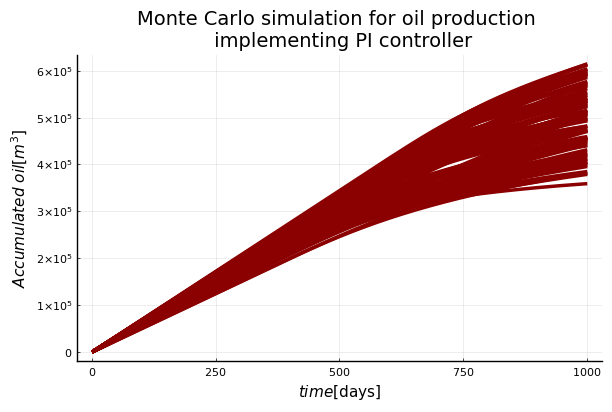

In [364]:
plot(Acc_qo_mon[:,:],lc=LCoil,lw=LW1, legend = false,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ oil[m^3]",title = "Monte Carlo simulation for oil production \n implementing PI controller")
figfile="AccumulatedoilMonteCarlo_PI_CF.svg"
savefig(figpath*figfile)

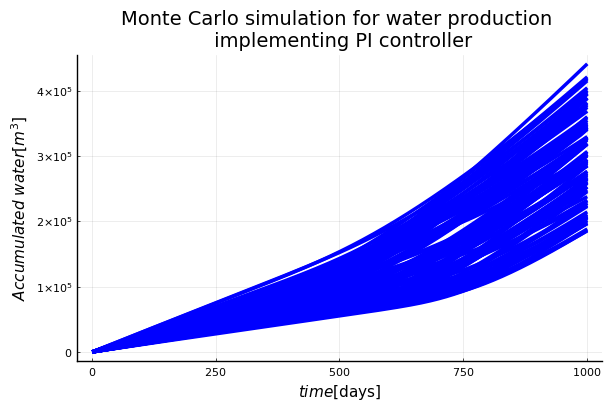

In [356]:
plot(Acc_qw_mon[:,:],lc=LCwater,lw=LW1, legend = false,
    xlabel = L"time[\mathrm{days}]",
    ylabel = L"Accumulated\ water[m^3]",title = "Monte Carlo simulation for water production \n implementing PI controller")
figfile="AccumulatedwaterMonteCarlo_PI_CF.svg"
savefig(figpath*figfile)

In [360]:
save("dataoil.jld", "dataoil", Acc_qo_mon)  #saving results

In [361]:
save("datawater.jld", "datawater", Acc_qw_mon)  #saving results

In [365]:
max_oil_PI = findmax(Acc_qo_mon[1001,:])

(614686.8166542668, 66)

In [366]:
max_water_PI = findmax(Acc_qw_mon[1001,:])

(440947.03045895376, 30)

In [368]:
min_oil_PI = findmin(Acc_qo_mon[1001,:])

(359039.0952441586, 30)

In [369]:
min_water_PI = findmin(Acc_qw_mon[1001,:])

(185309.59266303695, 66)